# NLP HW3: Movie Review Sentiment Analysis

*by Alexander Marinskiy*

## Task
1. Choose and argue your measure of a test's accuracy.
2. Build data processing and classification pipeline; Please compare word-embeddings vs classical methods 
3. Tune your model;

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## 1. Get Data

In [2]:
# read data
train = pd.read_csv('dataset/train.tsv', sep="\t")
test = pd.read_csv('dataset/test.tsv', sep="\t")
sub = pd.read_csv('dataset/sampleSubmission.csv', sep=",")

In [3]:
# check what dataset looks like
train.head(n=10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


The sentiment labels are:

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [4]:
print('There are', train.shape[0], 'rows and', train.shape[1], 'columns in our dataset')

There are 156060 rows and 4 columns in our dataset


In [5]:
# let's check the distribution of labels in dataset
train["Sentiment"].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

[Text(0.5, 0, 'Percent')]

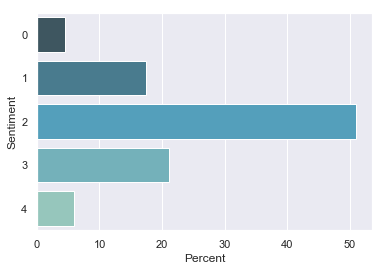

In [26]:
# visualizing the distribution
ax = sns.barplot(x="Sentiment", 
                 y="Sentiment", 
                 data=train, 
                 estimator=lambda x: len(x) / len(train) * 100, palette="GnBu_d", 
                 orient='h')
ax.set(xlabel="Percent")